In [1]:
%tensorflow_version 2.x

In [2]:
import zipfile
f = zipfile.ZipFile("./drive/My Drive/train.zip")
f.extractall("./datasets")

In [3]:
import glob
catfn = glob.glob("datasets/*/cat.*")
dogfn = glob.glob("datasets/*/dog.*")
print("貓圖片共有:", len(catfn), "張")
print("狗圖片共有:", len(dogfn), "張")
catans = [0] * len(catfn)
dogans = [1] * len(dogfn)

貓圖片共有: 12500 張
狗圖片共有: 12500 張


In [4]:
import pandas as pd
datas = {
    "path":catfn + dogfn,
    "target": catans + dogans    
}
df = pd.DataFrame(datas)
df

,path,target
0,datasets/train/cat.3019.jpg,0
1,datasets/train/cat.1006.jpg,0
2,datasets/train/cat.8065.jpg,0
3,datasets/train/cat.4266.jpg,0
4,datasets/train/cat.5186.jpg,0
...,...,...
24995,datasets/train/dog.9963.jpg,1
24996,datasets/train/dog.7129.jpg,1
24997,datasets/train/dog.541.jpg,1
24998,datasets/train/dog.8467.jpg,1


#### load_img 在需要顯示圖片的時候才顯示, 減少計算量

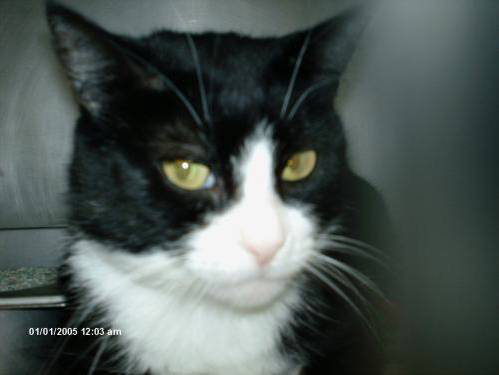

In [5]:
from tensorflow.keras.preprocessing.image import load_img
import random
import matplotlib.pyplot as plt
%matplotlib inline
p = random.randint(0, 24999)
image = load_img(df["path"][p])
image

In [6]:
# 拿 ResNet50
from tensorflow.keras.applications import  ResNet50
cnn = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
cnn.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
for i in cnn.layers:
  i.trainable = False
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [9]:
# 訓練之前把所有 list, series  轉成 np.array
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                    test_size=0.1)

In [10]:
# np.random.randint 可以隨機拿出多數張圖
x, y = x_train, y_train
idx = np.random.randint(0, x.shape[0], size=40)
idx

array([  268,  3357,  7342, 12010,  9599, 10936, 20889,  2500, 12800,
       11163, 19249, 20610, 15322, 10870,  2326, 15346,   268,  1010,
        5258,  6166,  4408, 22444, 13555, 21296,  6910,  1527, 13141,
        4723, 21741, 20085, 11477,  3796,  4689,  8329,  2810, 19379,
       18919,   737,  4104,   506])

In [11]:
# x_batch 為隨機一批 x的圖,
x_batch, y_batch = x[idx], y[idx]
y_batch # 約 20 張圖片的答案

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [12]:
# 用 keras 裡面給的預處理來處理圖片, 每一個模型都有自己的處理方式內建於 keras 內
from tensorflow.keras.applications.resnet50 import preprocess_input
# dataflow 回傳 (原圖batch, 處理後batch, 答案batch)
def dataflow(x, y, batch=20):
  idx = np.random.randint(0, x.shape[0], size=40)
  x_batch, y_batch = x[idx], y[idx]
  x_ori, x_pre = [], [] # 有些原圖還需要用, 先儲存
  for fp in x_batch:
    img = load_img(fp, target_size=(224, 224))
    img_np = np.array(img)
    x_ori.append(img_np) # 原本圖片儲存一份
    img_pre = preprocess_input(img_np)
    x_pre.append(img_pre)
  x_ori, x_pre = np.array(x_ori), np.array(x_pre)
  return (x_ori, x_pre, y_batch)
#print("原圖的情況:", x_ori.shape) # 20 張圖, 224, 224, 3
#print("預處理後的圖情況:", x_pre.shape)

#### 圖檔太大時使用批次訓練, 用 train_on_batch, 返回 ["loss", "accuracy"]
#### test_on_batch, 返回 ["val_loss", "val_accuracy"]
#### 參考: https://keras.io/zh/models/model/

In [13]:
# 開始訓練, 原圖沒用到不取名字用 _ 代替
for i in range(50):
  print("-"*10 + "目前訓練次數為:", i, "-" *10)
  _, x, y =  dataflow(x_train, y_train, batch=40)
  result = model.train_on_batch(x, y)
  print(["train"], result)
  # 驗證模型
  _, x , y = dataflow(x_test, y_test)
  result = model.test_on_batch(x, y)
  print(["validate"], result)

----------目前訓練次數為: 0 ----------
['train'] [1.1835925579071045, 0.550000011920929]
['validate'] [5.270102024078369, 0.8500000238418579]
----------目前訓練次數為: 1 ----------
['train'] [1.7003065347671509, 0.824999988079071]
['validate'] [13.62908935546875, 0.824999988079071]
----------目前訓練次數為: 2 ----------
['train'] [1.458816647529602, 0.8999999761581421]
['validate'] [21.7017822265625, 0.7749999761581421]
----------目前訓練次數為: 3 ----------
['train'] [0.1780576854944229, 0.949999988079071]
['validate'] [14.846887588500977, 0.8500000238418579]
----------目前訓練次數為: 4 ----------
['train'] [0.09215215593576431, 0.9750000238418579]
['validate'] [15.748072624206543, 0.875]
----------目前訓練次數為: 5 ----------
['train'] [0.1683487594127655, 0.9750000238418579]
['validate'] [21.40687370300293, 0.824999988079071]
----------目前訓練次數為: 6 ----------
['train'] [0.7277652025222778, 0.875]
['validate'] [5.918226718902588, 0.8999999761581421]
----------目前訓練次數為: 7 ----------
['train'] [1.1179430484771729, 0.9499999880790

In [14]:
# 預測
model.predict(x)

array([[2.8837365e-13, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 6.3190794e-13],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [9.9999976e-01, 2.3670347e-07],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0017943e-23, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.3533743e-15],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0601111e-20, 1.0000000e+00],
       [0.0000000e+00, 1.

In [15]:
timg, tx, ty = dataflow(x_test, y_test, 500)
model.evaluate(tx, ty)

2/2 [==============================] - 0s 36ms/step - loss: 1.5471 - accuracy: 0.9750


[1.5470925569534302, 0.9750000238418579]

In [16]:
# model 沒有 predict_calsses, 後續會移除, 用 predict + argmin = predict_classes
# argmax 找到最值得 index, 參數  axis = 1 指每一個列找出最大值
pre = model.predict(tx).argmax(axis=1)

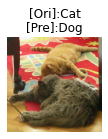

In [17]:
# 畫圖
trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]
# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)

#### ResNet50 看得比較深的 CNN 
  + val_accuracy = 0.97
#### 遷移學習 :
  + 需要把 BatchNormalization 在 Flatten之前放上, 讓資料流動更加平順
  + 如果訓練不好, 嘗試 Dropout 減少神經元
  + 由於 MLP 訓練的物件不多, 減少 MLP 層數叫好
  + 注意原本的 CNN 有沒有訓練過相似的東西, imagenet 沒有人物, model zoo 裡面可搜尋


#### 許多張大圖片時的處理方式 summary :
  + zip: 先解壓縮
  + 把貓狗圖片的路徑放入 DataFrame
  + load_img: kears 內建的圖案讀取套件
  + train_on_batch: 批次訓練 返回 ["loss", "accuracy"]
  + test_on_batch: 批次測試 返回 ["val_loss", "val_accuracy"]